<a href="https://colab.research.google.com/github/Ke-Pa-Sa/latex-/blob/master/ProjectML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
filename = "/spins_data_L16_modelIsing_N10_nT21_minT1.0_maxT5.0_2.csv"

file_path = filename

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# The DataFrame now contains the temperatures and spin configurations
print(df['Temperature'])

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
205    5.0
206    5.0
207    5.0
208    5.0
209    5.0
Name: Temperature, Length: 210, dtype: float64


In [4]:
# Regular expression pattern to match the parts of the filename
# The (?P<extra>\d+)? part makes the extra digits optional
pattern = r"/spins_data_L(?P<L>\d+)_model(?P<model>\w+)_N(?P<N>\d+)_nT(?P<nT>\d+)"

# Search for the pattern in the filename
match = re.search(pattern, filename)

# Extract the values if the pattern was found
if match:
    L = int(match.group('L'))
    model = match.group('model')
    N = int(match.group('N'))
    nT = int(match.group('nT'))
    print(f"L: {L}, model: {model}, N: {N}, nT: {nT}")
else:
    print("Pattern not found in the filename.")

L: 16, model: Ising, N: 10, nT: 21


In [5]:
# turms the string of spins into a tensor with the first entry being the number of channels (1), and the last two being the matrix representation of the spin configuration
df['Spins'] = df['Spins'].apply(lambda x: np.reshape(list(map(float, x.split(' '))), (L,L)))

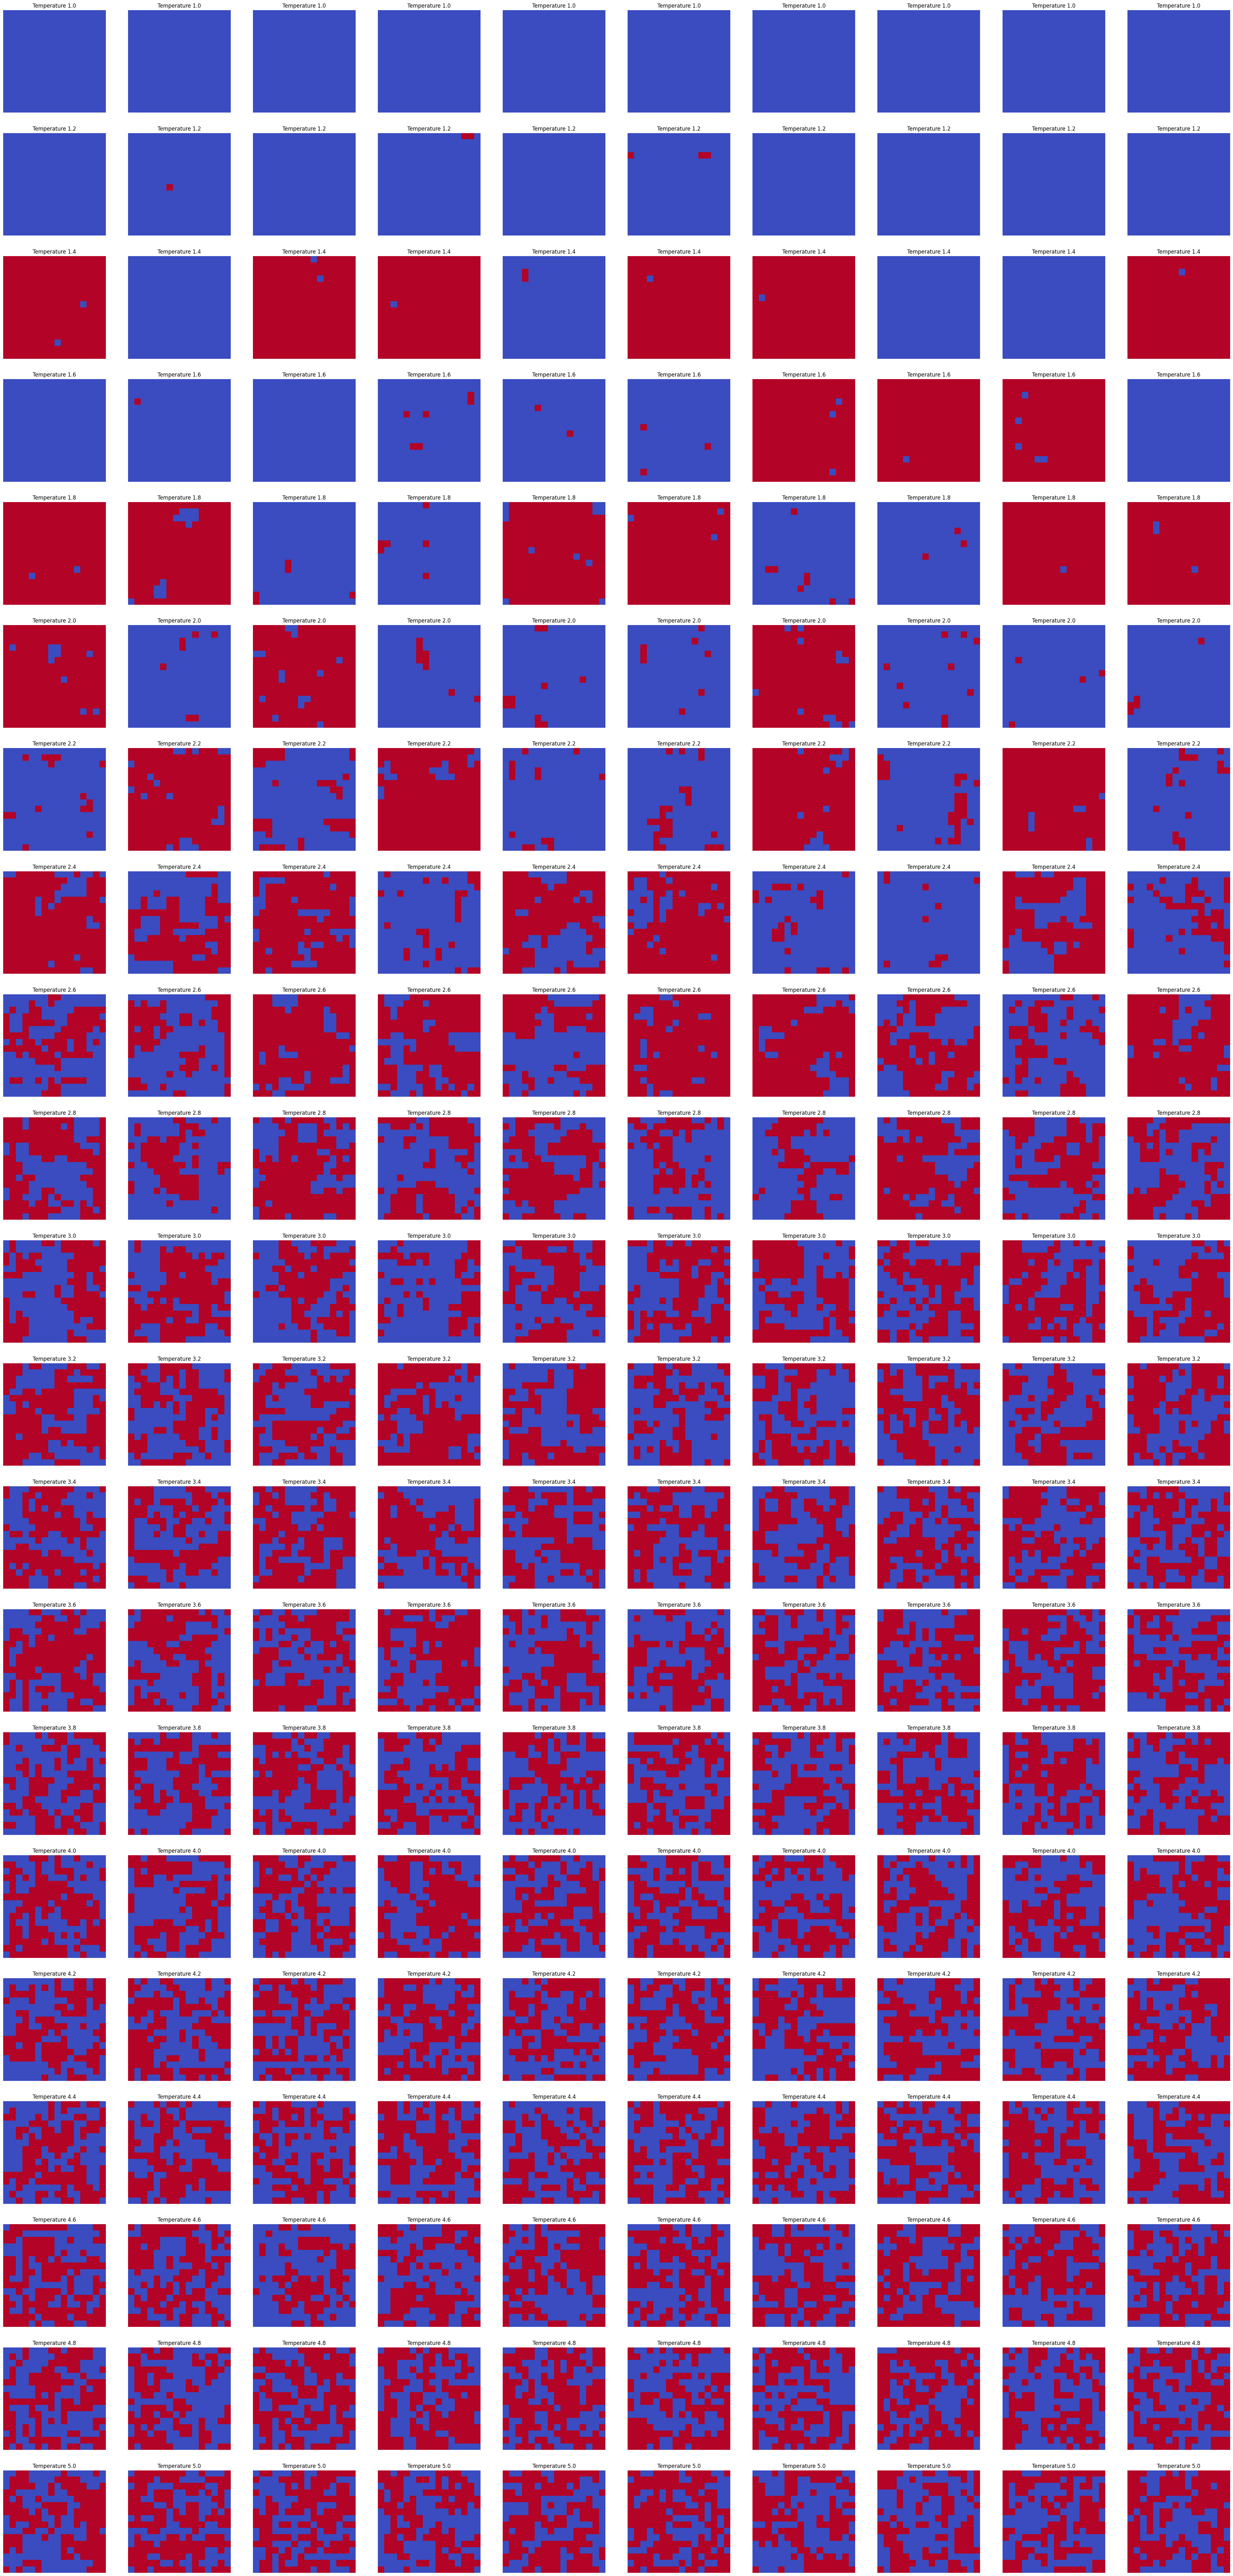

In [7]:
fig, axes = plt.subplots(nT, N, figsize=(int(N*5), int(nT*5)))

# display the spin config, the each row is one temperature

for i, spin in enumerate(df['Spins']):
    # Reshape the spins list into a LxL grid
    #spin_config = np.reshape(spin, (L, L))
    axes[i//N,i%N].imshow(spin, cmap='coolwarm', interpolation='nearest')
    T = df["Temperature"][i]
    axes[i//N,i%N].set_title(f"Temperature {T}")
    axes[i//N,i%N].axis('off') # Optionally, hide the axis

In [8]:
# create the data set with the X being the temperatures and the y being the spin configurations

X = torch.tensor(df['Temperature'].values, dtype=torch.float)
y = torch.stack([torch.tensor(spin_sequence, dtype=torch.float) for spin_sequence in df['Spins'].values]).unsqueeze(1)
dataset = TensorDataset(X, y)

In [9]:
train_ratio = 0.8 # 80% for training, 20% for testing

# Calculate the number of samples for training and testing
num_samples = len(dataset)
num_train = int(train_ratio * num_samples)
num_test = num_samples - num_train

print(num_train, num_test)

# Split the dataset
torch.manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

168 42


In [10]:
print(dataset[3][1].shape)
# example of one configuration: channel, dimentions

torch.Size([1, 16, 16])


In [11]:
# Basic example of a CNN, far from optimized
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        # here the first argument is the number of channels which must be 1
        # see doc for more details
        # the architecture is basic
        # might be good to use nn.Sequential
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(2048, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)
        self.act3 = nn.ReLU()

        self.fc5 = nn.Linear(10,1)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.act3(self.fc4(x))
        x = self.fc5(x)
        return x

In [12]:
# init model, define loss, define optimizer
model = CNN_1()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0, dampening=0.2, weight_decay=0.1, nesterov=False)


batch_size = 32 # Example batch size
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# show the shape of what is in the batches
for batch_idx, (temperatures, spin_configs) in enumerate(trainloader):
    print(f"Batch {batch_idx}:")
    print(f"Temperatures shape: {temperatures.shape}")
    print(f"Spin Configurations shape: {spin_configs.shape}")
    break

Batch 0:
Temperatures shape: torch.Size([32])
Spin Configurations shape: torch.Size([32, 1, 16, 16])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(10.7028, grad_fn=<MseLossBackward0>)
tensor(10.7065, grad_fn=<MeanBackward0>)
tensor(11.3420, grad_fn=<MseLossBackward0>)
tensor(11.3344, grad_fn=<MeanBackward0>)
tensor(7.7730, grad_fn=<MseLossBackward0>)
tensor(7.7581, grad_fn=<MeanBackward0>)
tensor(9.4610, grad_fn=<MseLossBackward0>)
tensor(9.3571, grad_fn=<MeanBackward0>)
tensor(4.5103, grad_fn=<MseLossBackward0>)
tensor(4.4329, grad_fn=<MeanBackward0>)
tensor(6.1841, grad_fn=<MseLossBackward0>)
tensor(5.8341, grad_fn=<MeanBackward0>)
Epoch 0: model mean square error 0.08
tensor(1.7173, grad_fn=<MseLossBackward0>)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



tensor(1.0907, grad_fn=<MeanBackward0>)
tensor(1.0453, grad_fn=<MseLossBackward0>)
tensor(0.8860, grad_fn=<MeanBackward0>)
tensor(1.9731, grad_fn=<MseLossBackward0>)
tensor(1.6288, grad_fn=<MeanBackward0>)
tensor(2.3015, grad_fn=<MseLossBackward0>)
tensor(1.6577, grad_fn=<MeanBackward0>)
tensor(3.0721, grad_fn=<MseLossBackward0>)
tensor(2.7356, grad_fn=<MeanBackward0>)
tensor(2.4267, grad_fn=<MseLossBackward0>)
tensor(1.8397, grad_fn=<MeanBackward0>)
Epoch 1: model mean square error 0.12
tensor(3.2594, grad_fn=<MseLossBackward0>)
tensor(2.8530, grad_fn=<MeanBackward0>)
tensor(4.1396, grad_fn=<MseLossBackward0>)
tensor(4.0064, grad_fn=<MeanBackward0>)
tensor(2.1203, grad_fn=<MseLossBackward0>)
tensor(1.9296, grad_fn=<MeanBackward0>)
tensor(1.7197, grad_fn=<MseLossBackward0>)
tensor(1.4184, grad_fn=<MeanBackward0>)
tensor(1.7596, grad_fn=<MseLossBackward0>)
tensor(1.3859, grad_fn=<MeanBackward0>)
tensor(1.5608, grad_fn=<MseLossBackward0>)
tensor(1.1068, grad_fn=<MeanBackward0>)
Epoch 2:

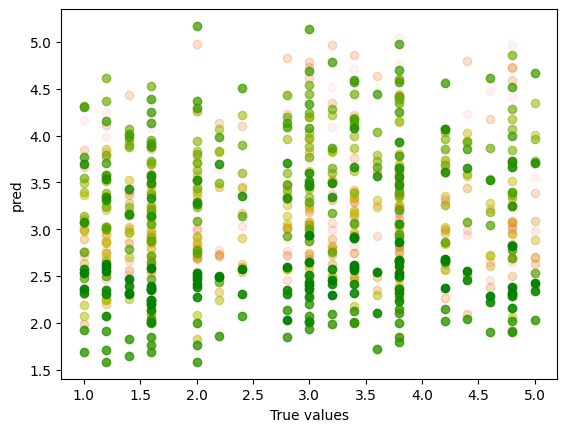

In [13]:
n_epochs = 20

y_pred_list = []
labels_list = []

fig, ax = plt.subplots()

# colour for visualisation
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),n_epochs))


for epoch in range(n_epochs):
    for labels, inputs in trainloader:
        # forward, backward, and then weight update
        #
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        print(loss)
        print(torch.mean((y_pred.squeeze() - labels)**2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse = 0
    count = 0
    for labels, inputs in testloader:
        y_pred = model(inputs)
        mse += torch.mean((y_pred.squeeze() - labels)**2)
        count += len(labels)
        y_pred_list.extend(y_pred.squeeze().tolist()) # Convert to list and add to y_pred_list
        labels_list.extend(labels.tolist()) # Convert to list and add to labels_list

    mse /= count
    print("Epoch %d: model mean square error %.2f" % (epoch, mse))

    # we make the plot directly here to delete the y_pred and labels list to not take up too much memory

    ax.scatter(labels_list, y_pred_list, alpha = epoch/n_epochs, c=str(colors[epoch]))
    ax.set_xlabel('True values')
    ax.set_ylabel('pred')
    y_pred_list.clear()
    labels_list.clear()

At the moment, it seems to choose to just guess approx 3, the average of the temperatures to minimize loss, either need better data, loss functions, architecture, optimizer... maybe even rethink the idea of a CNN and just go for a NN?
